In [205]:
import Levenshtein
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import shap
import warnings
import xgboost



from pandarallel import pandarallel
from scipy.stats import spearmanr

In [8]:
# Configuration
pandarallel.initialize(use_memory_fs=False)
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Read data

In [210]:
raw_data_path = '../data/raw/raw_kaggle_data/'
external_data_path = '../data/external/'

In [209]:
# You can get this data from: 
#https://www.kaggle.com/datasets/alejopaullier/aminoacids-physical-and-chemical-properties

aminoacids = pd.read_csv(f'{external_data_path}aminoacids.csv')
aminoacids.rename(
    columns={
        col: col.lower().strip().replace(' ', '_') 
        for col in aminoacids.columns
    }, inplace=True
)

In [212]:
protein_lists_pbd = pd.read_csv(
    f'{external_data_path}similar_protein_sequences.csv', 
    index_col="seq_id"
)

In [213]:
df_train_updates = pd.read_csv(f"{raw_data_path}train_updates_20220929.csv", index_col="seq_id")
df_train = pd.read_csv(f"{raw_data_path}train.csv", index_col="seq_id")
all_features_nan = df_train_updates.isnull().all("columns")
drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)
swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]
df_train = df_train[df_train.protein_sequence.notna()]
df_train = df_train[df_train.pH.notna()]

In [12]:
df_train.head()

protein_sequence   pH  \
seq_id                                                           
0       AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3       AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0   
4       AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0   

                              data_source    tm  
seq_id                                           
0       doi.org/10.1038/s41592-020-0801-4  75.7  
1       doi.org/10.1038/s41592-020-0801-4  50.5  
2       doi.org/10.1038/s41592-020-0801-4  40.5  
3       doi.org/10.1038/s41592-020-0801-4  47.2  
4       doi.org/10.1038/s41592-020-0801-4  49.5

# Process data

In [13]:
def similarity_levenshtein(protein1, protein2):
    distance = Levenshtein.distance(protein1, protein2)
    return distance

def change_positions(protein1, protein2):
    edit_operations = Levenshtein.editops(protein1, protein2)
    result_positions = [element[1] for element in edit_operations]
    return result_positions

def get_protein_similarity_groups(protein_sequence):
    lenght_protein = len(protein_sequence)
    upper_val = lenght_protein + 50
    lower_val = lenght_protein - 50

    filtered_df_train = df_train[
        df_train.protein_len.between(
            lower_val, upper_val
        )
    ]
    protein_seq_similarity_levenshtein = filtered_df_train.protein_sequence.apply(
        lambda protein_sequence2: similarity_levenshtein(
            protein_sequence, protein_sequence2
        )
    )
    levenshtein_list = protein_seq_similarity_levenshtein[
        protein_seq_similarity_levenshtein < 10 # Why 10? 
    ].index.to_list()    
    return levenshtein_list

In [14]:
df_train['protein_len'] = df_train.protein_sequence.str.len()

group_lists = df_train.protein_sequence.parallel_apply(
    get_protein_similarity_groups
)

In [23]:
group_lists_df = pd.DataFrame(group_lists).rename(columns={'protein_sequence': 'group_list'})
group_lists_df['group_list_len'] = group_lists_df.group_list.apply(len)
group_lists_df['group_list_str'] = group_lists_df.group_list.apply(str)
group_lists_df = group_lists_df[group_lists_df.group_list_len > 4]
relevant_groups = {
    gr:f'{i}_group'
    for i, gr in 
    enumerate(
        group_lists_df.group_list_str.unique()
    )
}
group_lists_df['group_str'] = group_lists_df.group_list_str.map(relevant_groups)
df_train.loc[group_lists_df.index, 'group'] = group_lists_df.group_str
reduced_df_train = df_train[df_train.group.notna()]
reduced_df_train['pdb_list'] = protein_lists_pbd.loc[reduced_df_train.index].protein_sequence

In [170]:
def get_paired_mutations(tmp):
    x2 = tmp.protein_sequence.to_list()
    zero_matrix = np.zeros((len(tmp), len(tmp)))
    single_distances_pairs = []
    new_rows = []
    for i, word in enumerate(x2):
        for j, word2 in enumerate(x2):
            distance = similarity_levenshtein(word, word2)
            zero_matrix[i,j] = distance
            if 0 < distance <= 1:
                #if i<j:
                #    #continue
                if True:#else:
                    single_distances_pairs.append((i,j))
                    row1 = tmp.iloc[i]
                    row2 = tmp.iloc[j]
                    dd = {}
                    indexes_of_change = change_positions(word, word2)
                    wildtype = word[indexes_of_change[0]]
                    mutation = word2[indexes_of_change[0]]
                    dd['seq1'] = row1.protein_sequence
                    dd['tm1'] = row1.tm
                    dd['ds1'] = row1.data_source
                    dd['pH1'] = row1.pH
                    dd['len1'] = row1.protein_len
                    dd['list1'] = row1.pdb_list
                    dd['seq2'] = row2.protein_sequence
                    dd['tm2'] = row2.tm
                    dd['ds2'] = row2.data_source
                    dd['pH2'] = row2.pH
                    dd['len2'] = row2.protein_len
                    dd['list2'] = row2.pdb_list
                    dd['mutation_type'] = distance
                    dd['mutation'] = mutation
                    dd['wildtype'] = wildtype
                    dd['edit_operations'] = indexes_of_change
                    new_rows.append(dd)
    new_df = pd.DataFrame(new_rows)
    return new_df

In [171]:
paired_df = reduced_df_train.groupby('group').apply(
    get_paired_mutations)

In [172]:
temporal_data = paired_df.copy().reset_index()
temporal_data = temporal_data.drop(
    ['level_1','ds1', 'ds2', 'len2'],
    axis=1
)

In [173]:
temporal_data['mutation_position'] =  temporal_data['edit_operations'].apply(lambda x: x[0])
temporal_data['relative_mutation_position'] = temporal_data['mutation_position']/temporal_data['len1']
temporal_data['d_pH'] = temporal_data['pH2'] - temporal_data['pH1']
temporal_data['d_tm'] = temporal_data['tm2'] - temporal_data['tm1'] 

In [174]:
def aminoacid_data(row):
    letter_wildtype = row.wildtype[0]
    letter_mutation = row.mutation[0]
    wild_amino = aminoacids[aminoacids.letter == letter_wildtype]
    muta_amino = aminoacids[aminoacids.letter == letter_mutation]
    cols = [
        'molecular_weight',
        'residue_weight',
        'pka1',
        'pkb2',
        'pkx3',
        'pl4',
        'h',
        'vsc',
        'p1',
        'p2',
        'sasa',
        'ncisc',
        'carbon',
        'hydrogen',
        'nitrogen',
        'oxygen',
        'sulfur'
    ]
    difference = (
        muta_amino[cols].reset_index(drop=True).T - 
        wild_amino[cols].reset_index(drop=True).T
    )
    result = dict(difference[0])
    result = {f'{key}__difference': result[key] for key in result.keys()}
    return result

In [175]:
temporal_data_aminoacid_info = pd.json_normalize(
    temporal_data.parallel_apply(
        aminoacid_data, axis=1
    )
)

In [176]:
temporal_data_aminoacid_info.head()

molecular_weight__difference  residue_weight__difference  pka1__difference  \
0                         42.08                       42.08              0.02   
1                        -42.08                      -42.08             -0.02   
2                         57.05                       57.05             -0.17   
3                         30.02                       30.03             -0.25   
4                        -30.02                      -30.03              0.25   

   pkb2__difference  pkx3__difference  pl4__difference  h__difference  \
0             -0.09               NaN            -0.02           0.44   
1              0.09               NaN             0.02          -0.44   
2             -0.56               NaN            -0.35          -1.47   
3             -0.59               NaN            -0.40          -0.67   
4              0.59               NaN             0.40           0.67   

   vsc__difference  p1__difference  p2__difference  sasa__difference  \
0             66.0            -3.2           0.140             0.750   
1            -66.0             3.2          -0.140            -0.750   
2             53.2             2.4           0.134             0.751   
3             23.8             0.5           0.062             0.344   
4            -23.8            -0.5          -0.062            -0.344   

   ncisc__difference  carbon__difference  hydrogen__difference  \
0           0.044485                 3.0                   6.0   
1          -0.044485                -3.0                  -6.0   
2           0.042024                 2.0                   3.0   
3          -0.003835                 1.0                   2.0   
4           0.003835                -1.0                  -2.0   

   nitrogen__difference  oxygen__difference  sulfur__difference  
0                   0.0                 0.0                 0.0  
1                   0.0                 0.0                 0.0  
2                   1.0                 1.0                 0.0  
3                   0.0                 1.0                 0.0  
4                   0.0                -1.0                 0.0

In [177]:
drop_cols = [
    'list1', 
#    'len1',
    'tm2',
    'list2',
    'mutation', 
    'wildtype', 
    'edit_operations',
    'mutation_position',
]

In [178]:
final_train_data = pd.concat([
    temporal_data.drop(drop_cols, axis=1),
    temporal_data_aminoacid_info], axis=1)
final_train_data

group                                               seq1   tm1  pH1  \
0       0_group  MKGMSKMAQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...  74.1  7.5   
1       0_group  MKGMSKMLQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...  67.3  7.5   
2       0_group  MKGMSKMPQFNLRWPREVADLVRKVAEENGRSVNSEIYQRVMESFK...  48.3  7.5   
3       0_group  MKGMSKMPQFNLRWPREVLDLVRAVAEENGRSVNSEIYQRVMESFK...  56.3  7.5   
4       0_group  MKGMSKMPQFNLRWPREVLDLVRTVAEENGRSVNSEIYQRVMESFK...  44.0  7.5   
...         ...                                                ...   ...  ...   
23335  94_group  QDWLTFQKKHITNTRDVDCDNIMSTNLTHCKDKNTFIYSRPEPVKA...  77.4  5.5   
23336  95_group  SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...  62.6  2.5   
23337  95_group  SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...  59.2  2.5   
23338  95_group  SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...  65.7  2.5   
23339  95_group  SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...  67.5  2.5   

        len1                                               seq2  pH2  \
0       53.0  MKGMSKMLQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...  7.5   
1       53.0  MKGMSKMAQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...  7.5   
2       53.0  MKGMSKMPQFNLRWPREVQDLVRKVAEENGRSVNSEIYQRVMESFK...  7.5   
3       53.0  MKGMSKMPQFNLRWPREVLDLVRTVAEENGRSVNSEIYQRVMESFK...  7.5   
4       53.0  MKGMSKMPQFNLRWPREVLDLVRAVAEENGRSVNSEIYQRVMESFK...  7.5   
...      ...                                                ...  ...   
23335  104.0  QDWLTFQKKHITNTRDVDCDNIMSTNLAHCKDKNTFIYSRPEPVKA...  5.5   
23336   68.0  SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...  2.5   
23337   68.0  SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...  2.5   
23338   68.0  SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...  2.5   
23339   68.0  SSCPGKSSWPHLVGVGGSVAKAIIERQNPNVKAVILEEGTPVTKDF...  2.5   

       mutation_type  relative_mutation_position  d_pH  ...  vsc__difference  \
0                1.0                    0.132075   0.0  ...             66.0   
1                1.0                    0.132075   0.0  ...            -66.0   
2                1.0                    0.339623   0.0  ...             53.2   
3                1.0                    0.433962   0.0  ...             23.8   
4                1.0                    0.433962   0.0  ...            -23.8   
...              ...                         ...   ...  ...              ...   
23335            1.0                    0.259615   0.0  ...            -23.8   
23336            1.0                    0.720588   0.0  ...             72.5   
23337            1.0                    0.720588   0.0  ...            -72.5   
23338            1.0                    0.750000   0.0  ...             53.2   
23339            1.0                    0.750000   0.0  ...            -53.2   

       p1__difference  p2__difference  sasa__difference  ncisc__difference  \
0                -3.2           0.140             0.750           0.044485   
1                 3.2          -0.140            -0.750          -0.044485   
2                 2.4           0.134             0.751           0.042024   
3                 0.5           0.062             0.344          -0.003835   
4                -0.5          -0.062            -0.344           0.003835   
...               ...             ...               ...                ...   
23335            -0.5          -0.062            -0.344           0.003835   
23336             3.2           0.173             1.077           0.010521   
23337            -3.2          -0.173            -1.077          -0.010521   
23338             2.4           0.134             0.751           0.042024   
23339            -2.4          -0.134            -0.751          -0.042024   

       carbon__difference  hydrogen__difference  nitrogen__difference  \
0                     3.0                   6.0                   0.0   
1                    -3.0                  -6.0                   0.0   
2                     2.0                   3.0        

In [179]:
def generate_graph(protein_sequence):
    from_to_dict = {
        'from':list(protein_sequence[:-1]),
        'to':list(protein_sequence[1:])
    }
    protein_sequence_directions = pd.DataFrame(from_to_dict)
    list_of_paths = protein_sequence_directions.groupby('from').to.agg(list).values.tolist()
    G=nx.Graph()
    for path in list_of_paths:
        nx.add_path(G, path)
    return G
    
def flatten_result_dict(result_dictionary):
    index = []
    values = []
    for key in result_dictionary.keys():
        for letter in result_dictionary[key].keys():
            index.append(f'{key}_{letter}')
            values.append(result_dictionary[key][letter])
    result = pd.Series(values, index=index)
    return result 

def get_graph_results(graph):
    result_dictionary = {
        'degree_dict':dict(graph.degree()),
        'pagerank_dict': nx.pagerank(graph),
        #'centrality_eigenvector': nx.eigenvector_centrality(graph),
        'centrality_degree': nx.degree_centrality(graph),
        'centrality_closeness': nx.closeness_centrality(graph),
    }
    result_dictionary_df = flatten_result_dict(result_dictionary=result_dictionary)
    return result_dictionary_df

In [180]:
graph_seq1 = final_train_data['seq1'].apply(generate_graph).apply(get_graph_results)
graph_seq2 = final_train_data['seq2'].apply(generate_graph).apply(get_graph_results)

In [181]:
for col in graph_seq1.columns:
    final_train_data[f'{col}_graph_diff'] = (
        graph_seq2[col]-graph_seq1[col]
    )

In [182]:
final_train_data.head()

group                                               seq1   tm1  pH1  \
0  0_group  MKGMSKMAQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...  74.1  7.5   
1  0_group  MKGMSKMLQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...  67.3  7.5   
2  0_group  MKGMSKMPQFNLRWPREVADLVRKVAEENGRSVNSEIYQRVMESFK...  48.3  7.5   
3  0_group  MKGMSKMPQFNLRWPREVLDLVRAVAEENGRSVNSEIYQRVMESFK...  56.3  7.5   
4  0_group  MKGMSKMPQFNLRWPREVLDLVRTVAEENGRSVNSEIYQRVMESFK...  44.0  7.5   

   len1                                               seq2  pH2  \
0  53.0  MKGMSKMLQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...  7.5   
1  53.0  MKGMSKMAQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...  7.5   
2  53.0  MKGMSKMPQFNLRWPREVQDLVRKVAEENGRSVNSEIYQRVMESFK...  7.5   
3  53.0  MKGMSKMPQFNLRWPREVLDLVRTVAEENGRSVNSEIYQRVMESFK...  7.5   
4  53.0  MKGMSKMPQFNLRWPREVLDLVRAVAEENGRSVNSEIYQRVMESFK...  7.5   

   mutation_type  relative_mutation_position  d_pH  ...  \
0            1.0                    0.132075   0.0  ...   
1            1.0                    0.132075   0.0  ...   
2            1.0                    0.339623   0.0  ...   
3            1.0                    0.433962   0.0  ...   
4            1.0                    0.433962   0.0  ...   

   centrality_degree_T_graph_diff  centrality_closeness_T_graph_diff  \
0                             NaN                                NaN   
1                             NaN                                NaN   
2                             NaN                                NaN   
3                             NaN                                NaN   
4                             NaN                                NaN   

   degree_dict_C_graph_diff  degree_dict_H_graph_diff  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   

   pagerank_dict_C_graph_diff  pagerank_dict_H_graph_diff  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   

   centrality_degree_C_graph_diff  centrality_degree_H_graph_diff  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                             NaN                             NaN   
4                             NaN                             NaN   

   centrality_closeness_C_graph_diff  centrality_closeness_H_graph_diff  
0                                NaN                                NaN  
1                                NaN                                NaN  
2                                NaN                                NaN  
3                                NaN                                NaN  
4                                NaN                                NaN  

[5 rows x 108 columns]

In [183]:
def aminoacid_window_letter_sum_func(df):
    position = df.relative_mutation_position * len(df.seq1)
    left_position = position - 2
    right_position = position + 2
    aminoacid_window = df.seq1[int(left_position):int(right_position + 1)]
    list_test = []
    for i, letter in enumerate(aminoacid_window):
        if i==2:
            continue
        list_test.append(aminoacids[aminoacids.letter==letter])
    if not list_test:
        return None
    concatenated_letters = pd.concat(list_test)
    total_vecinity = concatenated_letters.select_dtypes('number').sum()
    rival_vecinity = concatenated_letters.select_dtypes('number').head(2).sum()-concatenated_letters.select_dtypes('number').tail(2).sum()
    total_vecinity.rename(index={ix:f'total_sum_neighbour_{ix}' for ix in total_vecinity.index}, inplace=True)
    rival_vecinity.rename(index={ix:f'rival_dif_neighbour_{ix}' for ix in rival_vecinity.index}, inplace=True)
    vecinity_results = total_vecinity.append(rival_vecinity)
    return vecinity_results

In [184]:
vecinity_results = final_train_data.apply(
    aminoacid_window_letter_sum_func, axis=1
)

In [186]:
vecinity_results

total_sum_neighbour_molecular_weight  \
0                                    606.74   
1                                    606.74   
2                                    528.57   
3                                    497.60   
4                                    497.60   
...                                     ...   
23335                                539.62   
23336                                544.63   
23337                                544.63   
23338                                626.76   
23339                                626.76   

       total_sum_neighbour_residue_weight  total_sum_neighbour_pka1  \
0                                  534.69                      8.46   
1                                  534.69                      8.46   
2                                  456.50                      8.75   
3                                  425.53                      9.15   
4                                  425.53                      9.15   
...                                   ...                       ...   
23335                              467.56                      8.16   
23336                              472.58                      8.47   
23337                              472.58                      8.47   
23338                              554.70                      9.68   
23339                              554.70                      9.68   

       total_sum_neighbour_pkb2  total_sum_neighbour_pkx3  \
0                         36.42                     10.53   
1                         36.42                     10.53   
2                         38.49                      7.90   
3                         37.97                     12.48   
4                         37.97                     12.48   
...                         ...                       ...   
23335                     37.85                     14.18   
23336                     37.74                     20.66   
23337                     37.74                     20.66   
23338                     37.65                     12.48   
23339                     37.65                     12.48   

       total_sum_neighbour_pl4  total_sum_neighbour_h  \
0                        26.61                  -0.52   
1                        26.61                  -0.52   
2                        17.93                   0.50   
3                        28.68                   0.25   
4                        28.68                   0.25   
...                        ...                    ...   
23335                    24.05                   0.17   
23336                    27.20                  -1.94   
23337                    27.20                  -1.94   
23338                    28.63                   0.74   
23339                    28.63                   0.74   

       total_sum_neighbour_vsc  total_sum_neighbour_p1  \
0                        390.3                    32.7   
1                        390.3                    32.7   
2                        267.0                    36.1   
3                        275.5                    30.4   
4                        275.5                    30.4   
...                        ...                     ...   
23335                    275.8                    32.4   
23336                    279.8                    33.5   
23337                    279.8                    33.5   
23338                    415.5                    27.0   
23339                    415.5                    27.0   

       total_sum_neighbour_p2  ...  rival_dif_neighbour_vsc  \
0                       0.910  ...                     -2.1   
1                       0.910  ...                     -2.1   
2                       0.582  ...                      0.0   
3                       0.617  ...                     77.5   
4                       0.617  ...                     77.5   
...                       ...  ...                      ...   
23335                   0.678  ..

In [187]:
final_train_data = pd.concat([final_train_data, vecinity_results], axis=1)

In [188]:
for i in range(3):
    final_train_data[f'random_{i}'] = np.random.randint(0, 1000, len(final_train_data))

 # Train-test splits

In [189]:
unique_groups = final_train_data.group.unique()
test_groups = np.random.choice(
    unique_groups, int(len(unique_groups)*0.3)
)
remaining_groups = list(set(unique_groups) - set(test_groups))
dev_groups = np.random.choice(
    remaining_groups, int(len(unique_groups)*0.2)
)

train_groups = list(set(remaining_groups) - set(dev_groups))

test_data = final_train_data[final_train_data.group.isin(test_groups)]
dev_data = final_train_data[final_train_data.group.isin(dev_groups)]
train_data = final_train_data[final_train_data.group.isin(train_groups)]

non_train_data = ['group', 'd_tm', 'seq1', 'seq2', 'tm1']
X_train, y_train = train_data.drop(non_train_data, axis=1), train_data.d_tm
X_test, y_test = test_data.drop(non_train_data, axis=1), test_data.d_tm
X_dev, y_dev = test_data.drop(non_train_data, axis=1), test_data.d_tm

# Train model 

In [198]:
model = xgboost.XGBRegressor(
    n_estimators=100000,
    max_depth=6,
    learning_rate=0.005,
    subsample=0.8,
    colsample_bytree=0.8,
)

model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_dev, y_dev)],
    early_stopping_rounds=1000,
    verbose=100
)


[0]	validation_0-rmse:10.87035	validation_1-rmse:12.36962
[100]	validation_0-rmse:9.48150	validation_1-rmse:12.26892
[200]	validation_0-rmse:8.67233	validation_1-rmse:12.43324
[300]	validation_0-rmse:8.15679	validation_1-rmse:12.40067
[400]	validation_0-rmse:7.73933	validation_1-rmse:12.27041
[500]	validation_0-rmse:7.29361	validation_1-rmse:12.19761
[600]	validation_0-rmse:6.93505	validation_1-rmse:12.15319
[700]	validation_0-rmse:6.67690	validation_1-rmse:12.11390
[800]	validation_0-rmse:6.45212	validation_1-rmse:12.09923
[900]	validation_0-rmse:6.27196	validation_1-rmse:12.04545
[1000]	validation_0-rmse:6.10964	validation_1-rmse:12.01418
[1100]	validation_0-rmse:5.95441	validation_1-rmse:11.91545
[1200]	validation_0-rmse:5.80821	validation_1-rmse:11.90315
[1300]	validation_0-rmse:5.66487	validation_1-rmse:11.86154
[1400]	validation_0-rmse:5.54572	validation_1-rmse:11.82555
[1500]	validation_0-rmse:5.42236	validation_1-rmse:11.81714
[1600]	validation_0-rmse:5.31475	validation_1-rmse:

[13700]	validation_0-rmse:1.32228	validation_1-rmse:11.15651
[13800]	validation_0-rmse:1.31162	validation_1-rmse:11.15586
[13900]	validation_0-rmse:1.30188	validation_1-rmse:11.15497
[14000]	validation_0-rmse:1.29110	validation_1-rmse:11.15396
[14100]	validation_0-rmse:1.27995	validation_1-rmse:11.15261
[14200]	validation_0-rmse:1.26980	validation_1-rmse:11.14972
[14300]	validation_0-rmse:1.25917	validation_1-rmse:11.14870
[14400]	validation_0-rmse:1.24947	validation_1-rmse:11.14792
[14500]	validation_0-rmse:1.24058	validation_1-rmse:11.14808
[14600]	validation_0-rmse:1.23008	validation_1-rmse:11.14659
[14700]	validation_0-rmse:1.21967	validation_1-rmse:11.14606
[14800]	validation_0-rmse:1.20937	validation_1-rmse:11.14557
[14900]	validation_0-rmse:1.19957	validation_1-rmse:11.14489
[15000]	validation_0-rmse:1.18983	validation_1-rmse:11.14572
[15100]	validation_0-rmse:1.18029	validation_1-rmse:11.14516
[15200]	validation_0-rmse:1.17093	validation_1-rmse:11.14454
[15300]	validation_0-rms

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.005, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

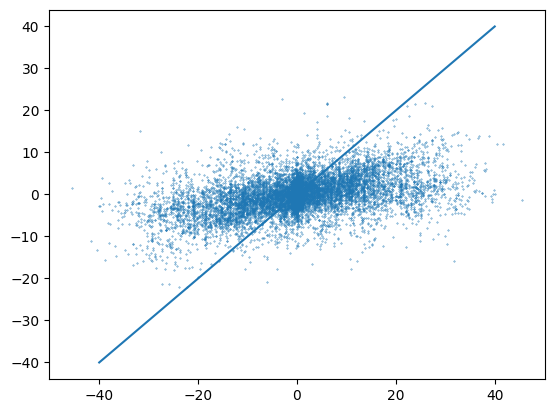

In [199]:
plt.scatter(
    y_test,
    model.predict(X_test),
    s=0.1
)
plt.plot([-40,40], [-40,40])

In [200]:
spearmanr(
    y_test,
    model.predict(X_test)
)

SpearmanrResult(correlation=0.443437342477638, pvalue=0.0)

In [204]:
X_train.head().to_csv('../data/processed/train_data_head.csv')

In [202]:
model.save_model("../models/model1.ubj")

<BarContainer object of 140 artists>

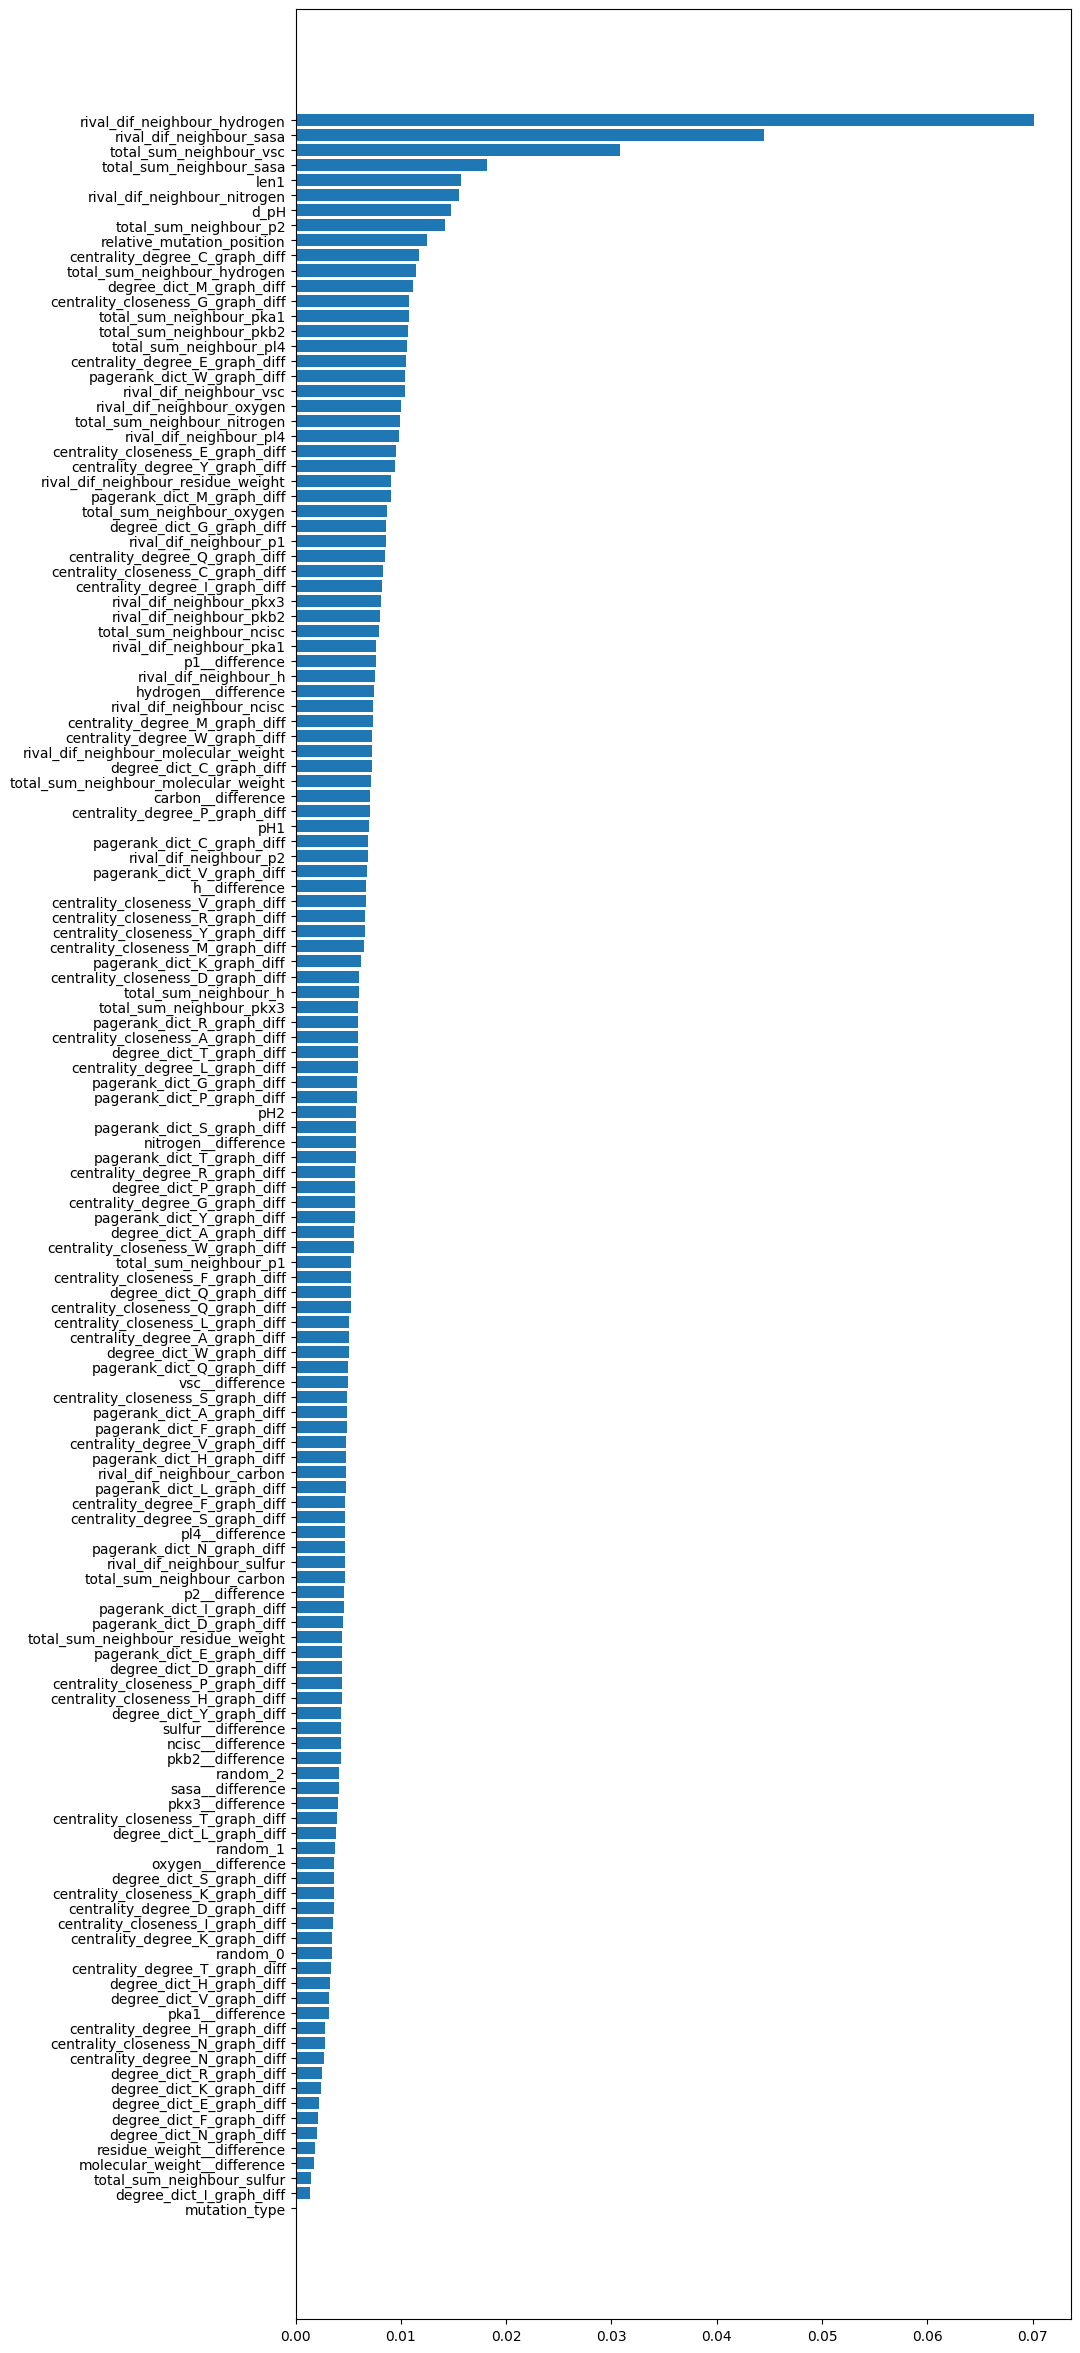

In [157]:
feature_importances_df = pd.Series(
    model.feature_importances_, index=X_test.columns
).sort_values()

plt.figure(figsize=(10,30))
plt.barh(feature_importances_df.index,feature_importances_df)

In [158]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

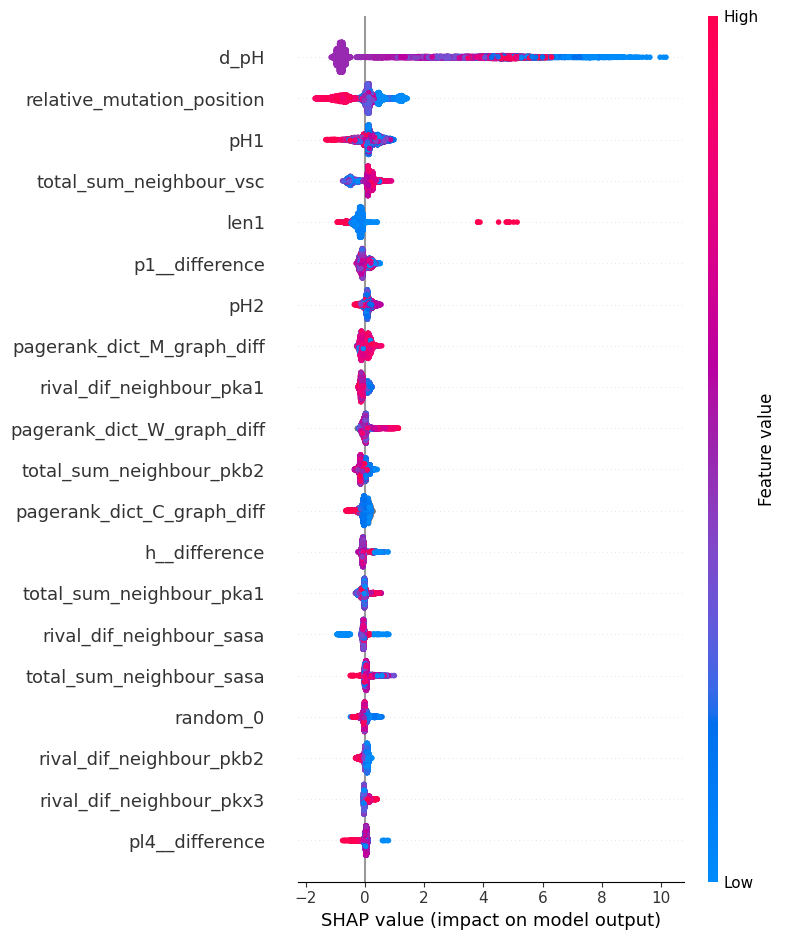

In [159]:
shap.summary_plot(shap_values, X_test)

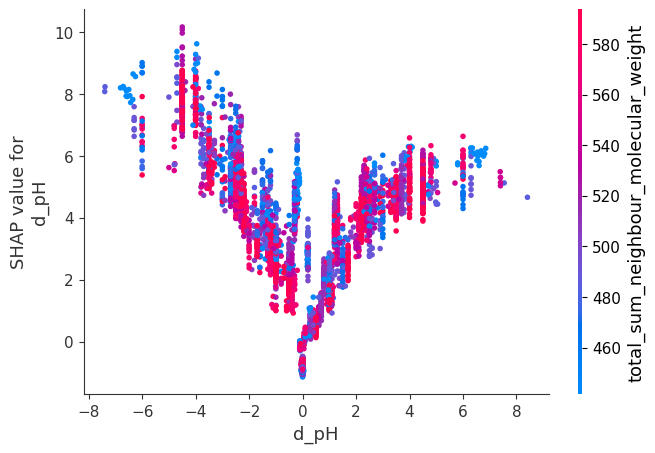

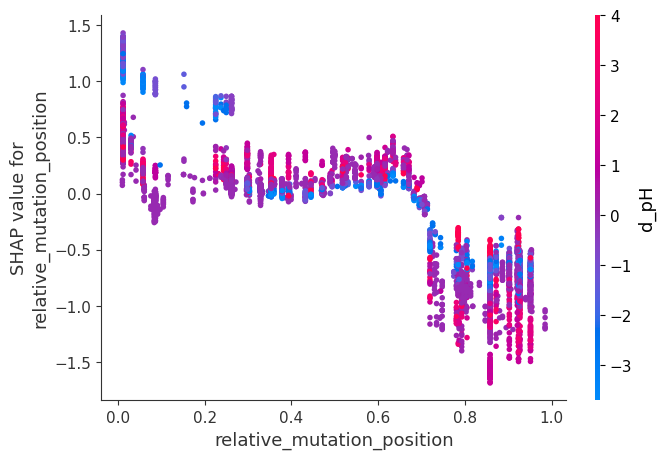

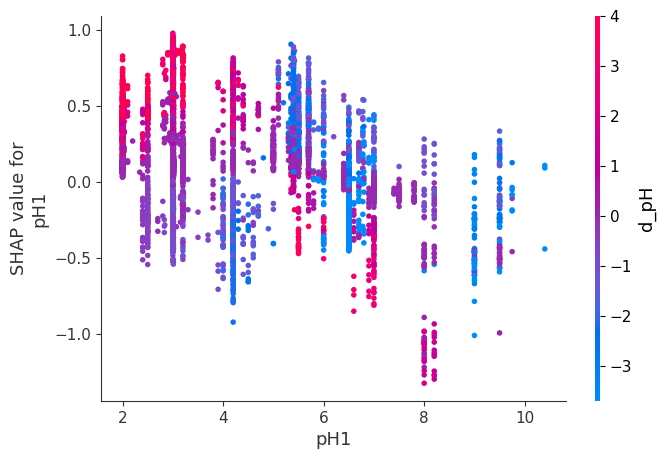

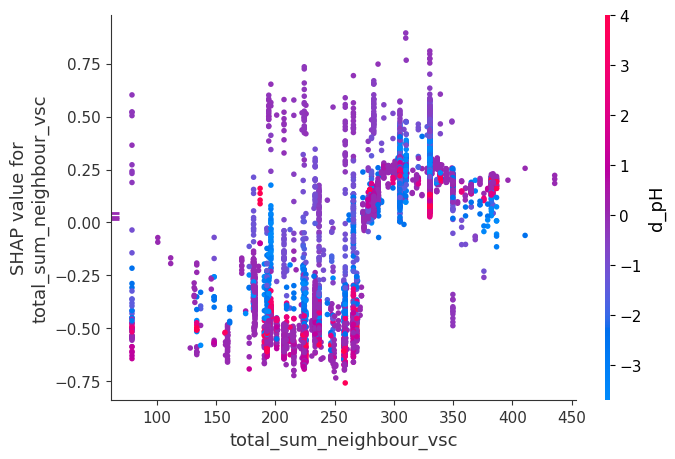

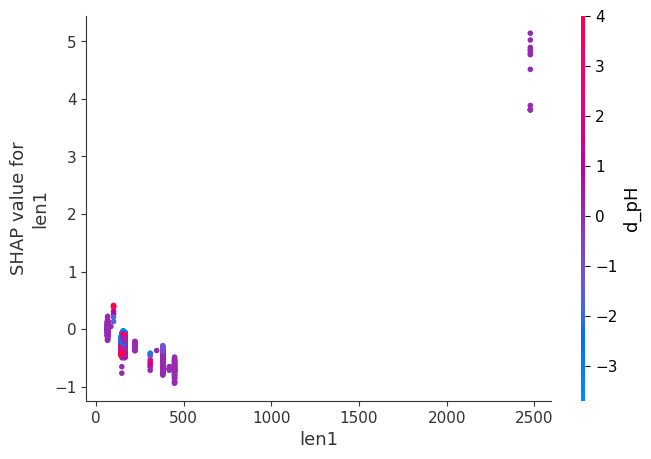

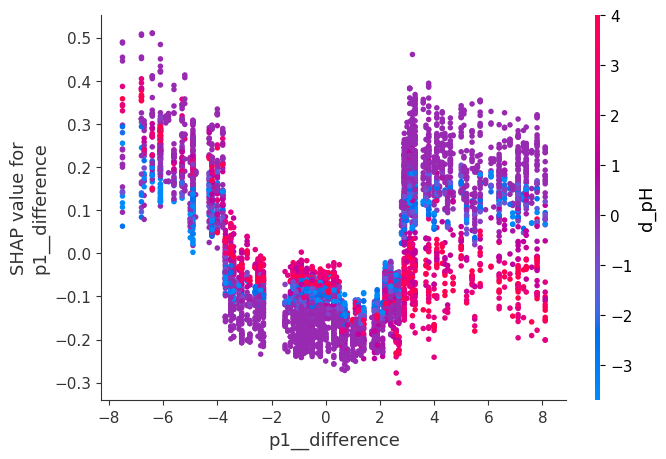

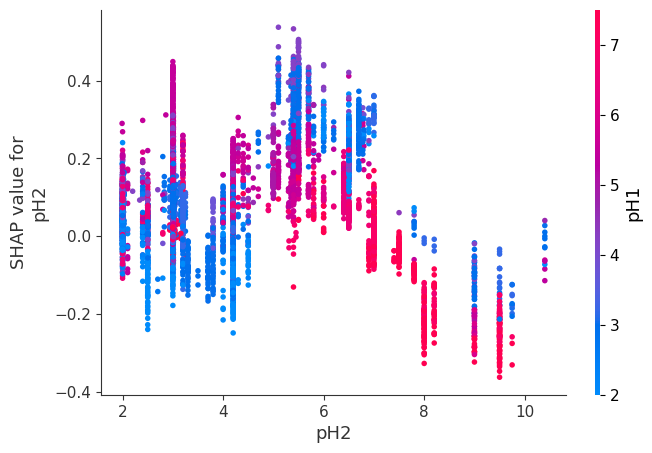

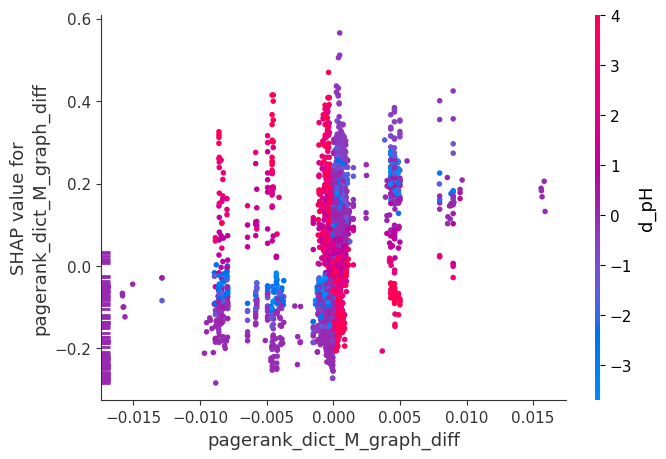

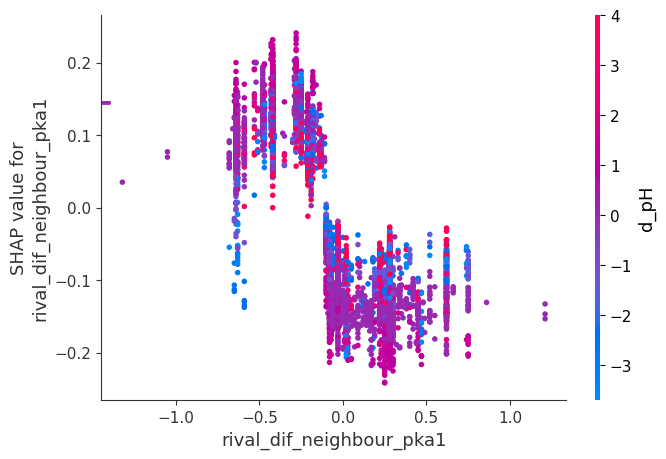

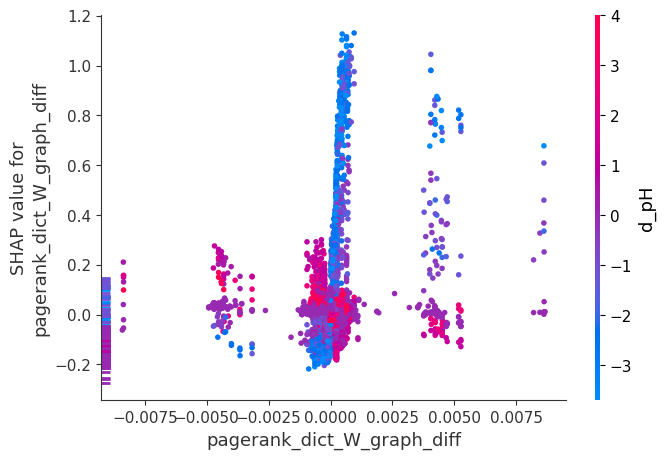

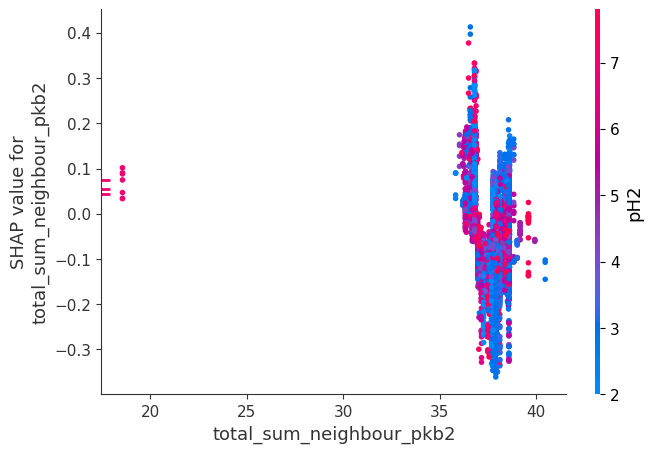

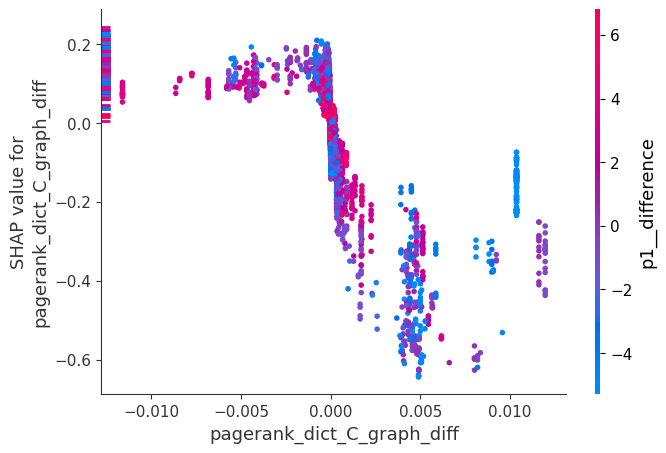

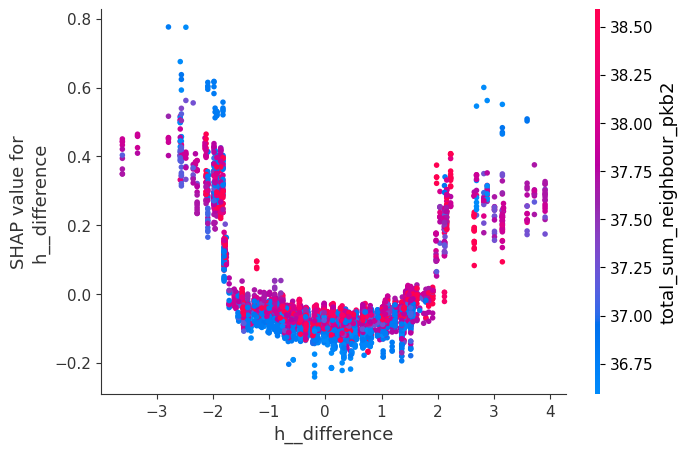

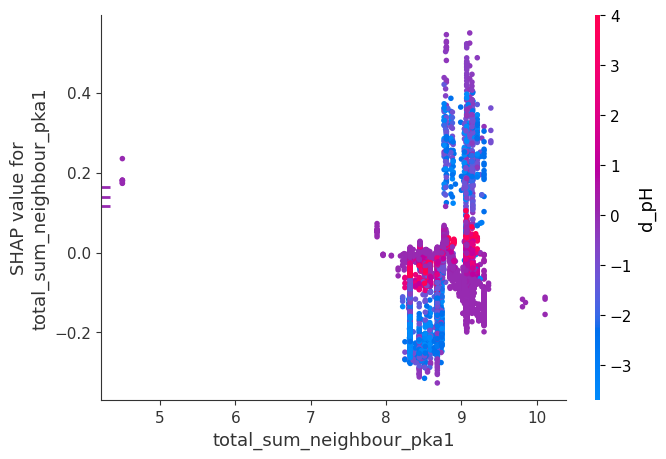

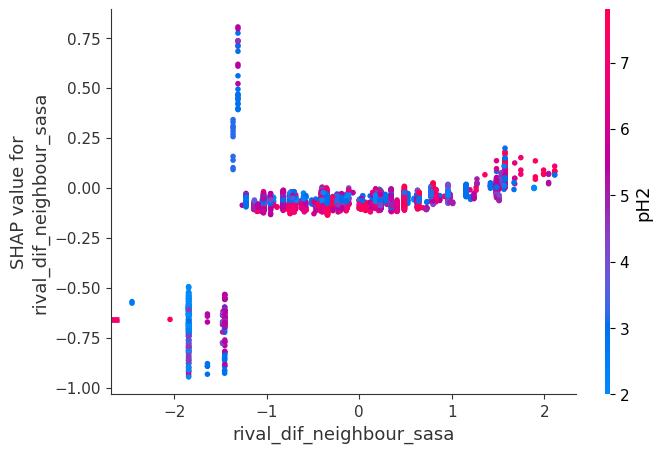

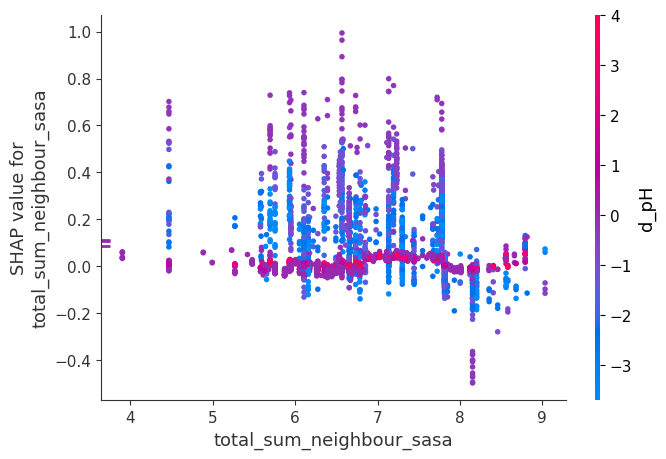

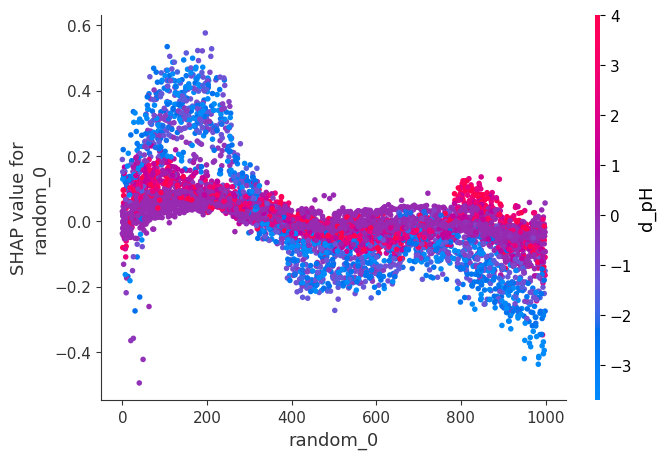

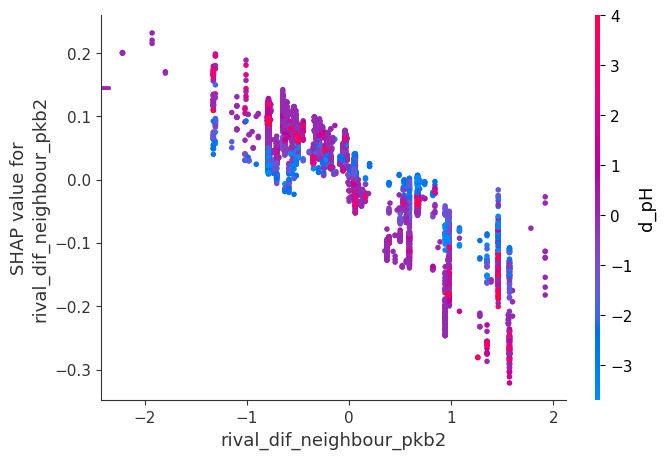

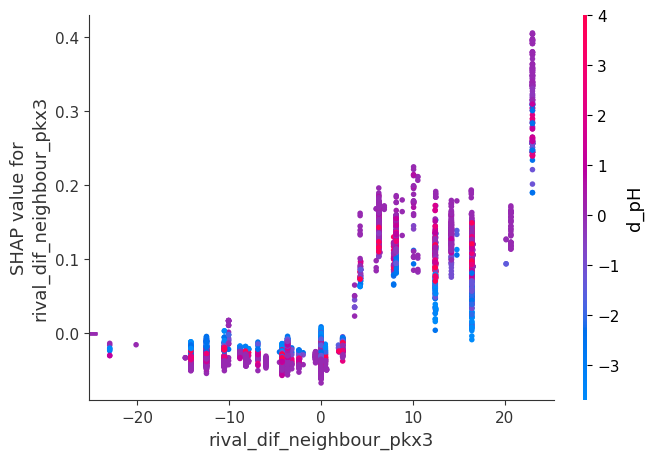

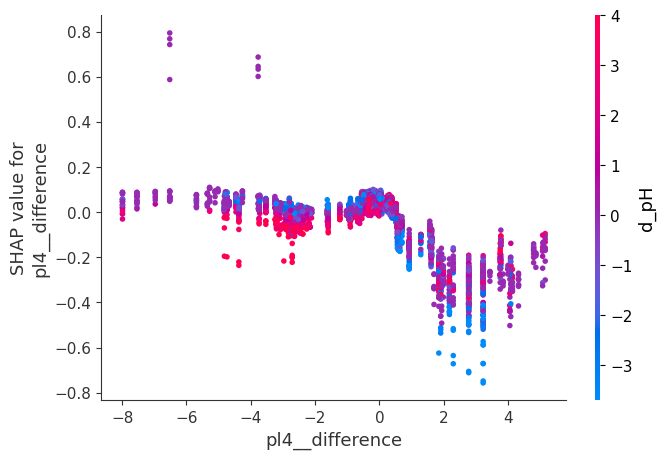

In [160]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, X_test)

In [196]:
model = xgboost.XGBClassifier(
    n_estimators=100000,
    max_depth=4,
    learning_rate=0.001,
    subsample=0.6,
    colsample_bytree=0.2,
)

model.fit(
    X_train, 
    y_train > 0, 
    eval_set=[(X_train, y_train > 0), (X_dev, y_dev > 0)],
    eval_metric=['auc', 'logloss'],
    early_stopping_rounds=1000,
    verbose=100,

)


[0]	validation_0-auc:0.64138	validation_0-logloss:0.69305	validation_1-auc:0.50232	validation_1-logloss:0.69314
[100]	validation_0-auc:0.82161	validation_0-logloss:0.68068	validation_1-auc:0.71575	validation_1-logloss:0.68866
[200]	validation_0-auc:0.82598	validation_0-logloss:0.66936	validation_1-auc:0.71162	validation_1-logloss:0.68459
[300]	validation_0-auc:0.82736	validation_0-logloss:0.65981	validation_1-auc:0.71115	validation_1-logloss:0.68135
[400]	validation_0-auc:0.83061	validation_0-logloss:0.65049	validation_1-auc:0.71243	validation_1-logloss:0.67788
[500]	validation_0-auc:0.82973	validation_0-logloss:0.64250	validation_1-auc:0.70886	validation_1-logloss:0.67537
[600]	validation_0-auc:0.83127	validation_0-logloss:0.63462	validation_1-auc:0.71005	validation_1-logloss:0.67251
[700]	validation_0-auc:0.83298	validation_0-logloss:0.62757	validation_1-auc:0.71121	validation_1-logloss:0.66991
[800]	validation_0-auc:0.83680	validation_0-logloss:0.62072	validation_1-auc:0.71225	valid

[7200]	validation_0-auc:0.91008	validation_0-logloss:0.46219	validation_1-auc:0.71678	validation_1-logloss:0.62238
[7300]	validation_0-auc:0.91069	validation_0-logloss:0.46103	validation_1-auc:0.71696	validation_1-logloss:0.62208
[7400]	validation_0-auc:0.91127	validation_0-logloss:0.45988	validation_1-auc:0.71656	validation_1-logloss:0.62204
[7500]	validation_0-auc:0.91185	validation_0-logloss:0.45876	validation_1-auc:0.71602	validation_1-logloss:0.62219
[7600]	validation_0-auc:0.91246	validation_0-logloss:0.45762	validation_1-auc:0.71628	validation_1-logloss:0.62185
[7700]	validation_0-auc:0.91299	validation_0-logloss:0.45656	validation_1-auc:0.71639	validation_1-logloss:0.62168
[7800]	validation_0-auc:0.91353	validation_0-logloss:0.45550	validation_1-auc:0.71565	validation_1-logloss:0.62193
[7900]	validation_0-auc:0.91414	validation_0-logloss:0.45438	validation_1-auc:0.71546	validation_1-logloss:0.62188
[8000]	validation_0-auc:0.91459	validation_0-logloss:0.45343	validation_1-auc:0.

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.001, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

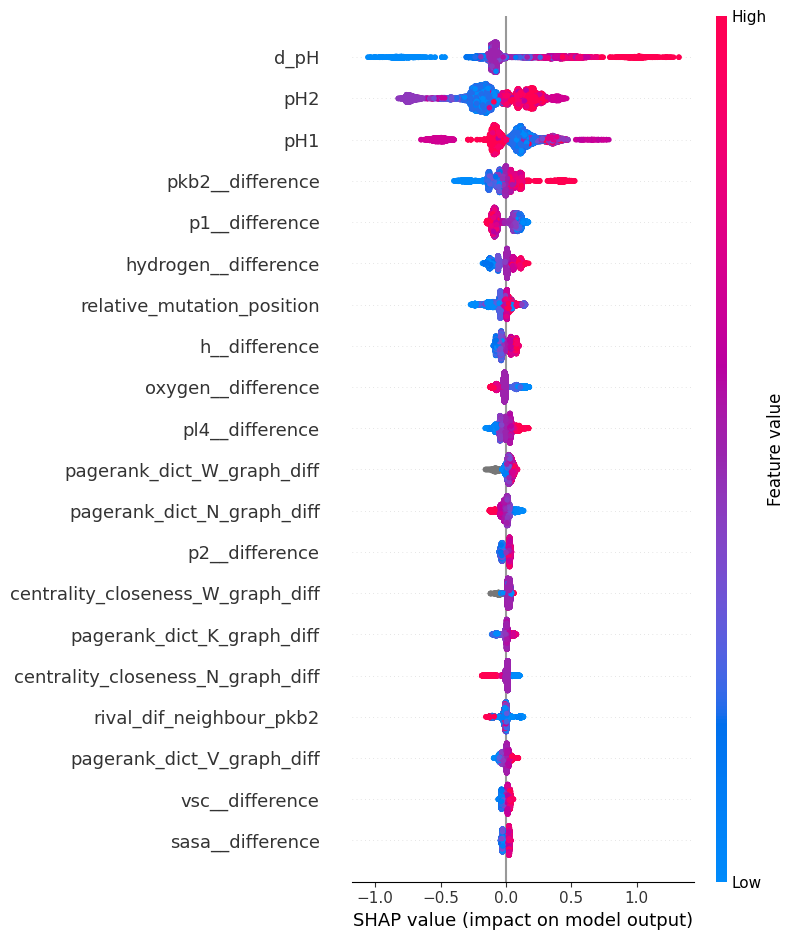

In [197]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

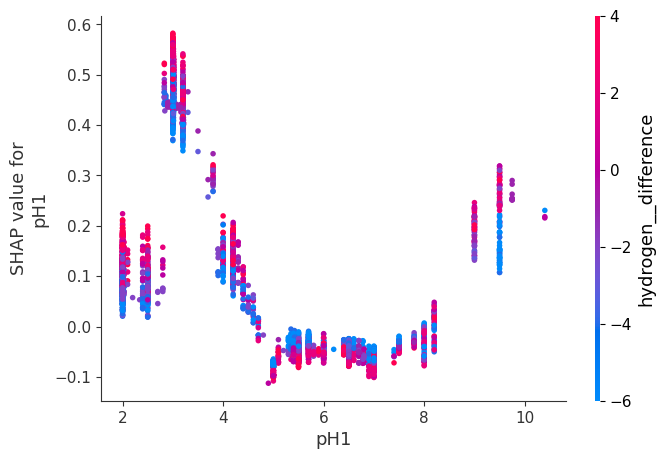

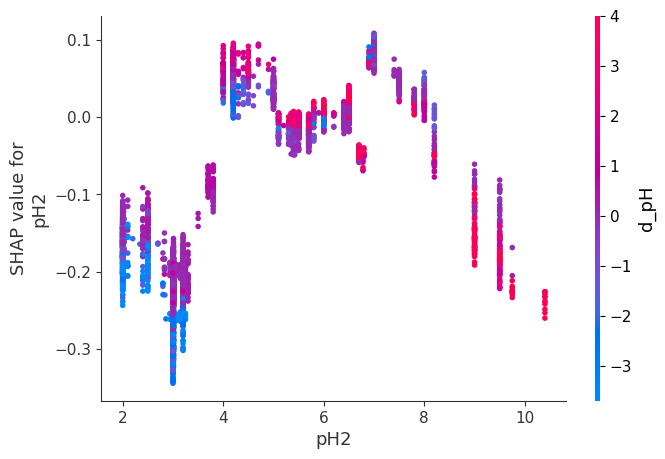

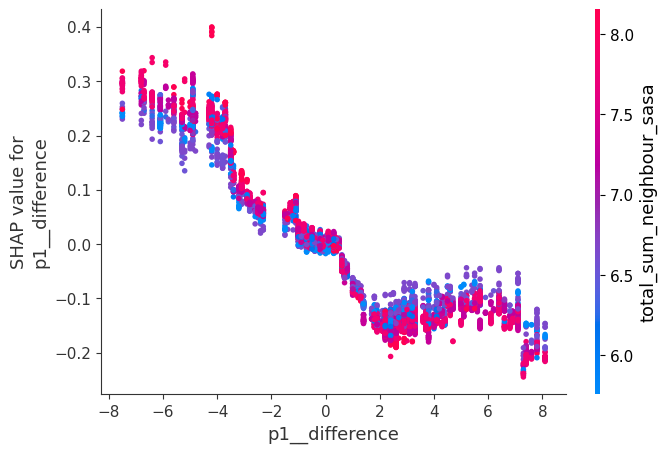

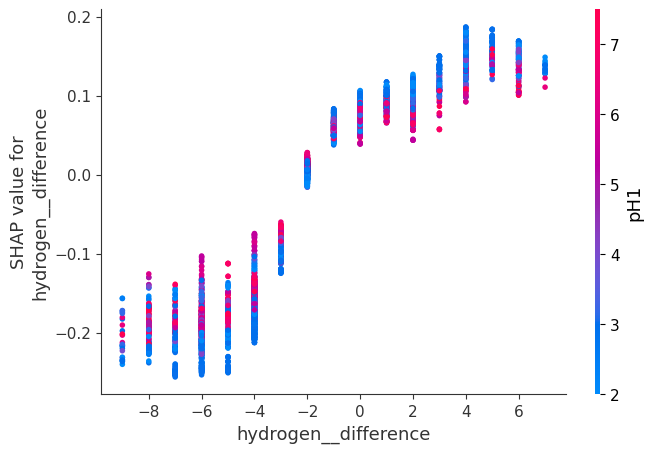

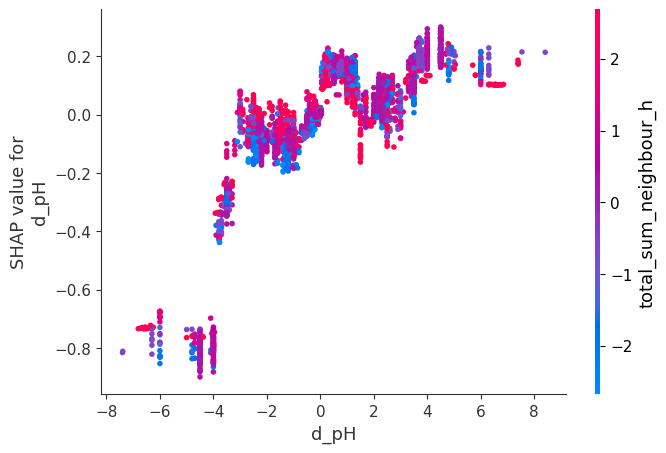

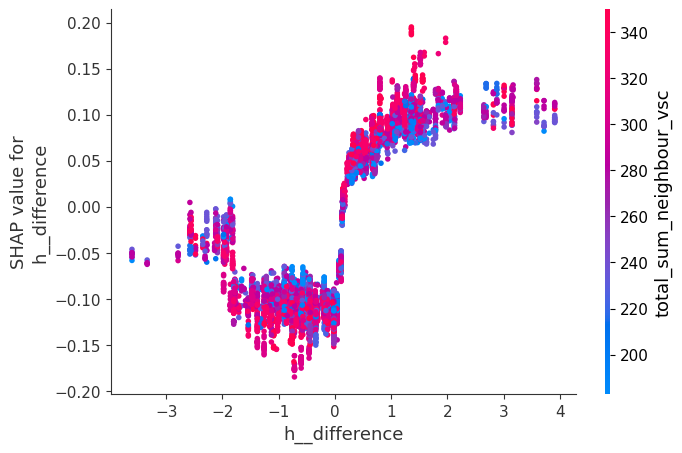

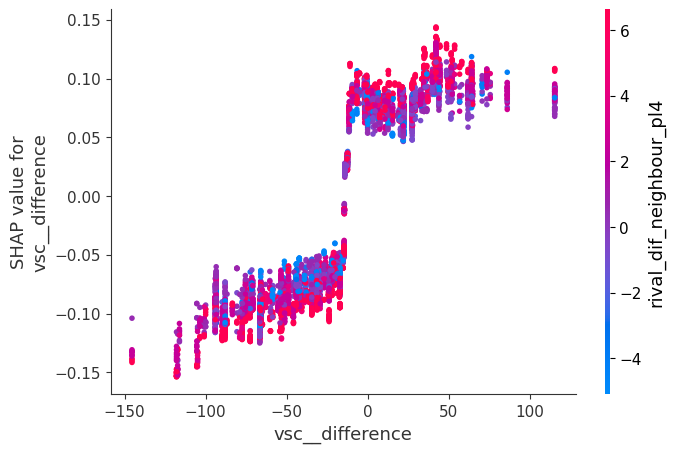

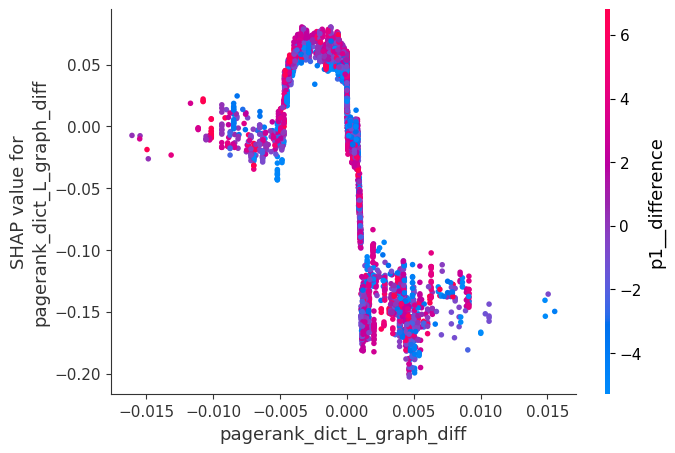

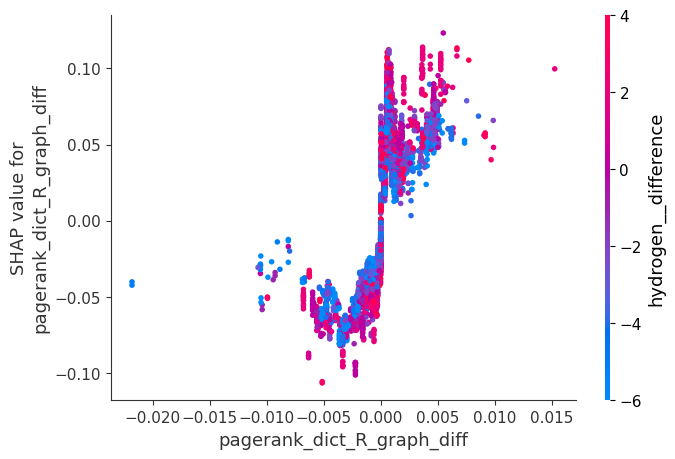

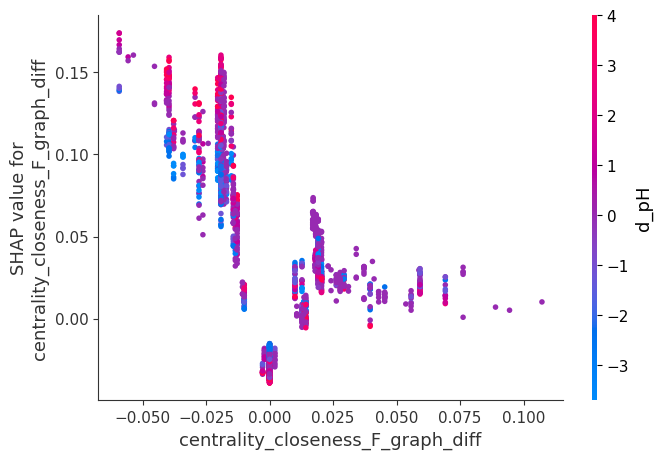

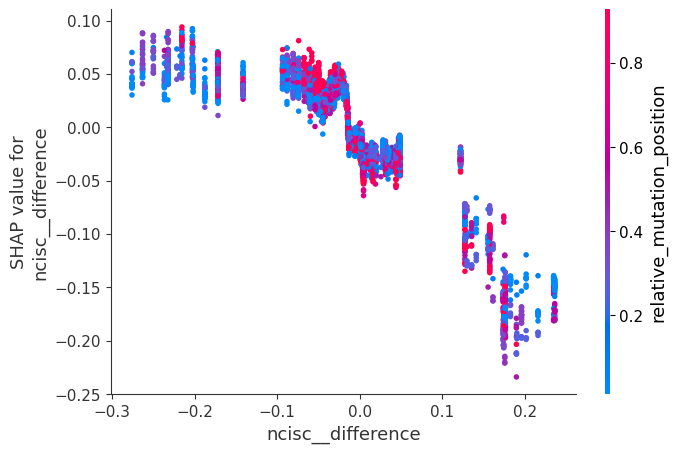

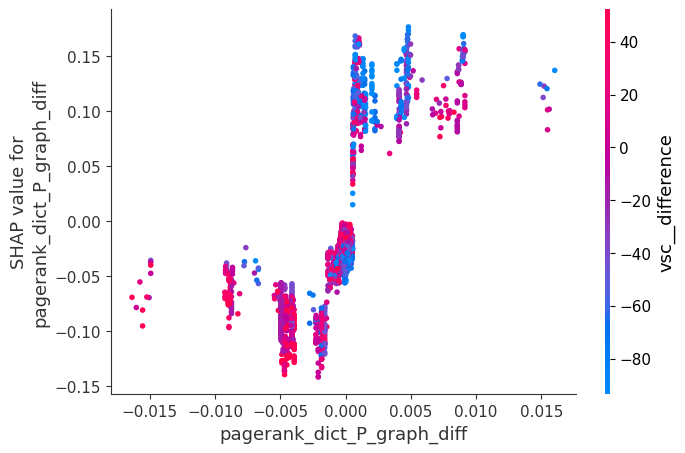

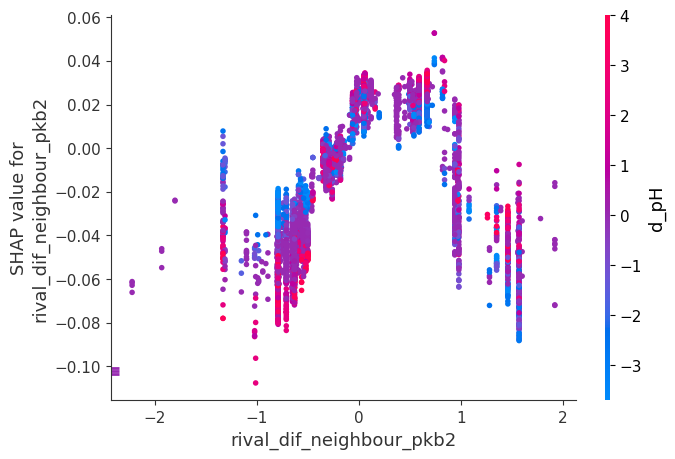

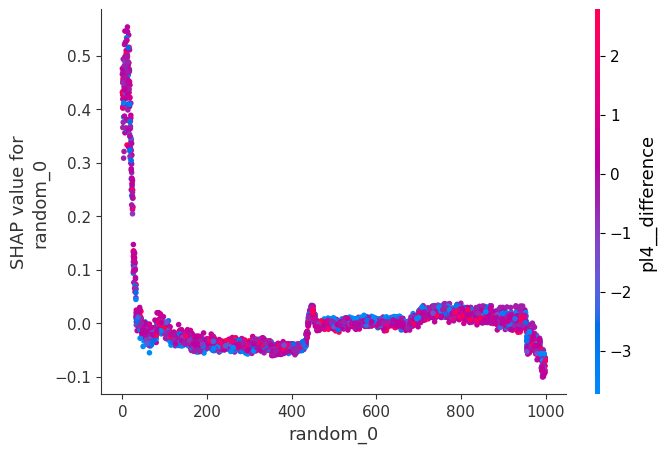

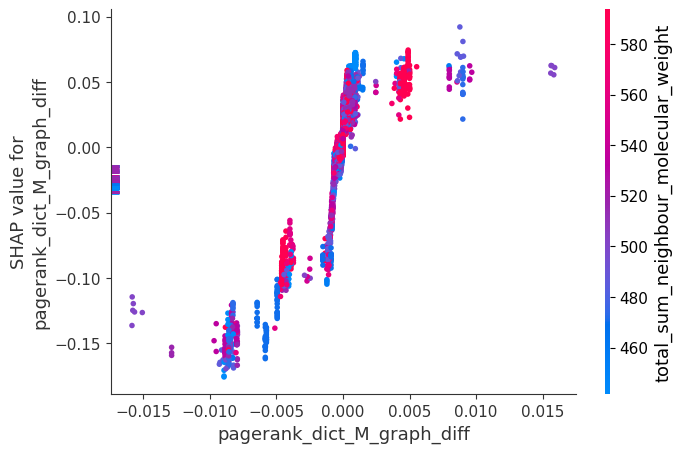

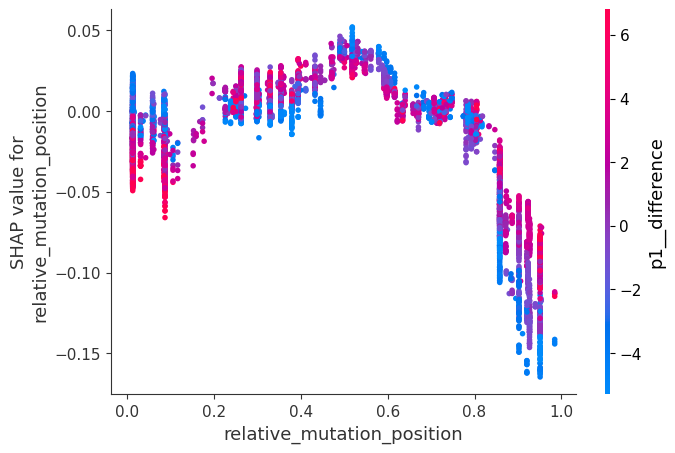

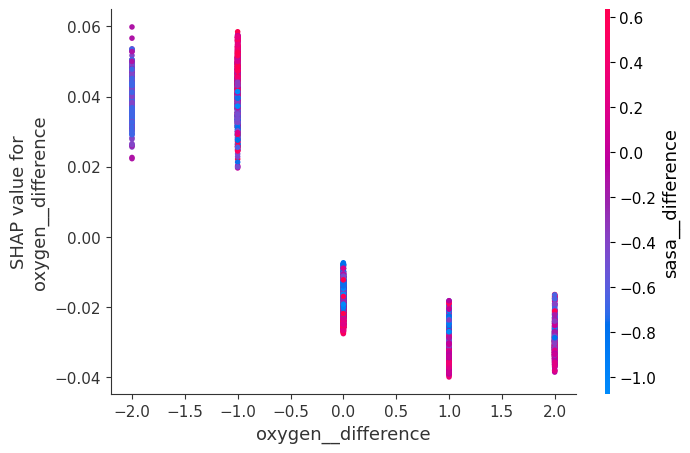

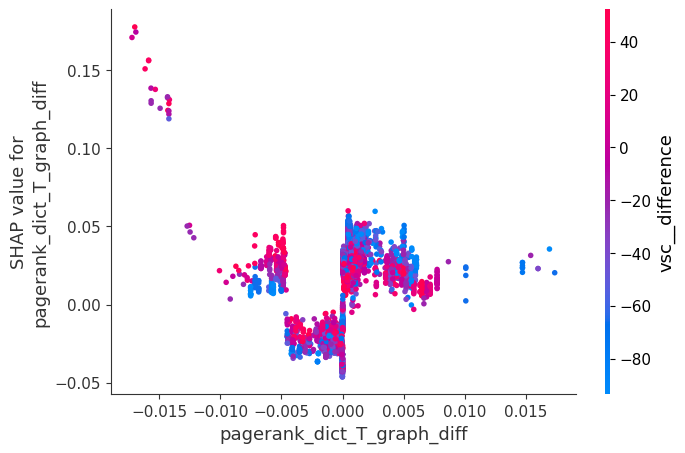

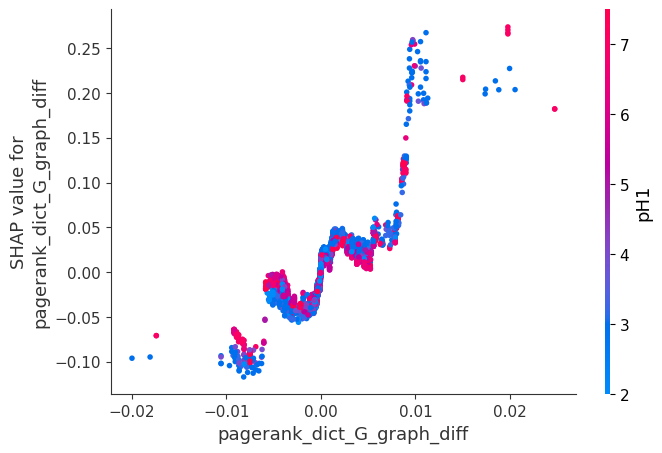

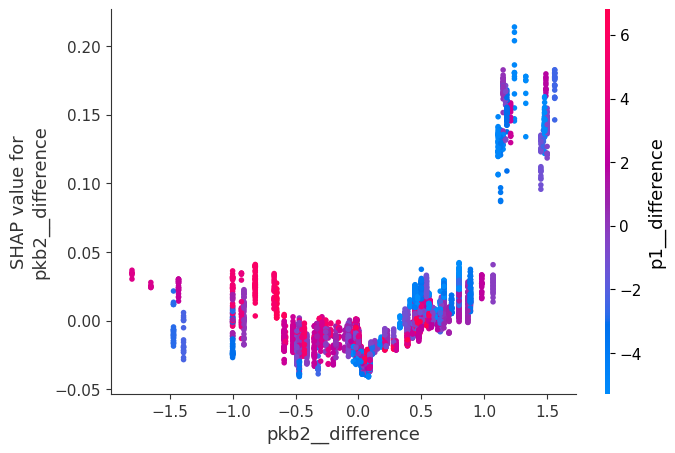

In [153]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, X_test)